# Importing required modules and dependencies


In [ ]:
#to execute any cell in the file, this should be executed first
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
from sklearn.exceptions import UndefinedMetricWarning
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Data Processing and Splitting

  Load dataset and check for missing values

In [82]:
#load the dataset in the memory
data = pd.read_csv("Heart Disease.csv")
#check for missing values in the dataset
print(data.isna().sum())

male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
HeartDisease         0
dtype: int64


Standardise the data

In [83]:
#based on above, we fill missing values with most appropriate estimate
#the estimate is decided by inferring from the dataset explicitly

#fill missing values with median in glucose, heartRate, totChol
data['glucose'] = data['glucose'].fillna(data['glucose'].median())
data['heartRate'] = data['heartRate'].fillna(data['glucose'].median())
data['totChol'] = data['totChol'].fillna(data['totChol'].median())

#fill missing values with mode in BPMeds, education
data['BPMeds'] = data['BPMeds'].fillna(data['BPMeds'].mode()[0])
data['education'] = data['education'].fillna(data['education'].mode()[0])

#fill missing values with mean in BMI, cigsPerDay(ceil)
data['BMI'] = data['BMI'].fillna(data['BMI'].mean())
data['cigsPerDay'] = data['cigsPerDay'].fillna(np.ceil(data['cigsPerDay'].mean()))

#verify the changes made in dataset, sum of missing values should be 0
print(data.isna().sum())

male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
HeartDisease       0
dtype: int64


In [84]:
#splitting data into target and features
x = data.drop(columns = 'HeartDisease') #features
y = data['HeartDisease'] #target

#splitting data into 70:30 (train:temp)
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.30, random_state=42, stratify=y)
#random state (can be any integer, using 42 due to wide use and reasons) and stratify ensures
#that the class distribution (consistency and comparability) is the same in each set

#splitting temp into 50:50 (test:validation)
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)
#this gives us the required split of 70:15:15 (train: test: validation)

# a) Model Implementation & Plots

Scratch implementation of Logistic Regression using Batch Gradient Descent

In [87]:
#sigmoid function
def sigmoid(z):
  return 1 / (1 + np.exp(-z))

#loss function (cross-entropy loss)
def loss_func(y, h):
  return -np.mean(y * np.log(h + 1e-9) + (1-y) * np.log(1-h + 1e-9)) #1e-9 term to resolve log(0)

#prediction after finding weights
def predict(x, weights, bias, threshold=0.5):
  probs = sigmoid(np.dot(x, weights) + bias)
  return [1 if p >= threshold else 0 for p in probs]

#function for logistic regression batch gradient descent
def lr_bgd(x_train, y_train, learning_rate, iterations, x_val, y_val):
  n = len(y_train) #number of training samples
  #arrays required to track losses and accuracies for plots
  loss_train = np.zeros(iterations)
  loss_val = np.zeros(iterations)
  acc_train = np.zeros(iterations)
  acc_val = np.zeros(iterations)
  #initialise weights and bias as 0
  weights = np.zeros(x_train.shape[1])
  bias = 0

  for i in range(iterations):
    h_train = sigmoid(np.dot(x_train, weights) + bias) #calculate hypothesis
    #calculate gradients
    dw = np.dot(x_train.T, (h_train - y_train)) / n
    db = np.sum(h_train - y_train) / n
    #update weights and bias
    weights = weights - learning_rate * dw
    bias = bias - learning_rate * db

    #calculate the losses
    loss_train[i] = loss_func(y_train, h_train)
    h_val = sigmoid(np.dot(x_val, weights) + bias) #calculate hypothesis for validation data
    loss_val[i] = loss_func(y_val, h_val)

    #track training accuracy
    train_predictions = predict(x_train, weights, bias)
    acc_train[i] = np.mean(train_predictions == y_train)

    #track validation accuracy
    val_predictions = predict(x_val, weights, bias)
    acc_val[i] = np.mean(val_predictions == y_val)

  return weights, bias, loss_train, acc_train, loss_val, acc_val

Training model on testing set and plotting curves

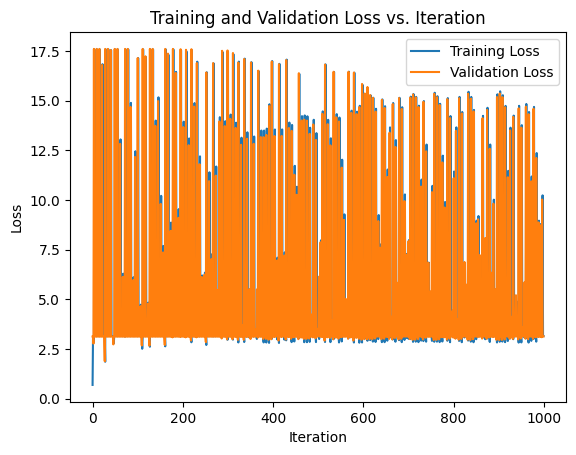

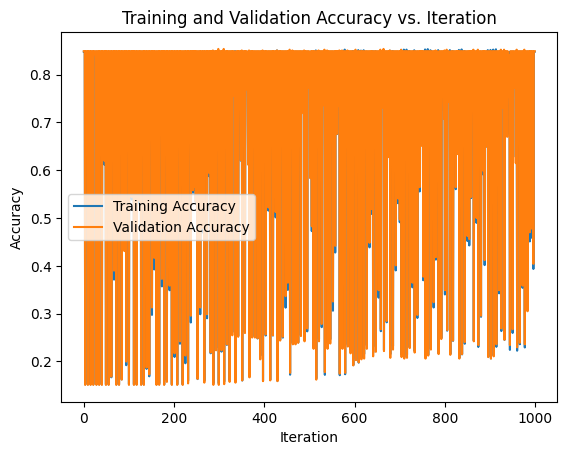

In [ ]:
#hyperparameters
learning_rate = 0.01 #learning rate (alpha) for model
iterations = 1000 #number of iterations (epochs)

#train model
weights_a, bias_a, loss_train_a, acc_train_a, loss_val_a, acc_val_a = lr_bgd(x_train, y_train, learning_rate, iterations, x_val, y_val)

#plotting the curves
#loss vs iteration
plt.plot(range(iterations), loss_train_a, label='Training Loss')
plt.plot(range(iterations), loss_val_a, label='Validation Loss')
plt.title('Training and Validation Loss vs. Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

#accuracy vs iteration
plt.plot(range(iterations), acc_train_a, label='Training Accuracy')
plt.plot(range(iterations), acc_val_a, label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs. Iteration')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

We cannot comment on the convergence of the model from these plots as they don't converge at all.  
(From the plots) Even after training the model for significant iterations, we still see large losses and low accuracy in further iterations. The model's performance is quite similar in testing and validation data.

# b) Min-max scaling and No scaling

Scratch implementation of min-max scaler

In [ ]:
class MinMaxScaler:
  def fit(self, x):
    self.min = x.min(axis=0) #find min for each feature
    self.max = x.max(axis=0) #find max for each feature
    return self

  def transform(self, x):
    return (x - self.min) / (self.max - self.min)

Applying the min-max scaling to dataset, and no scaling is simply the results we recieved in part a.

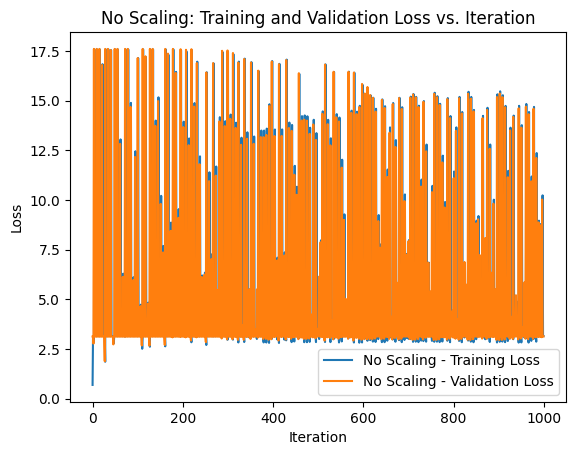

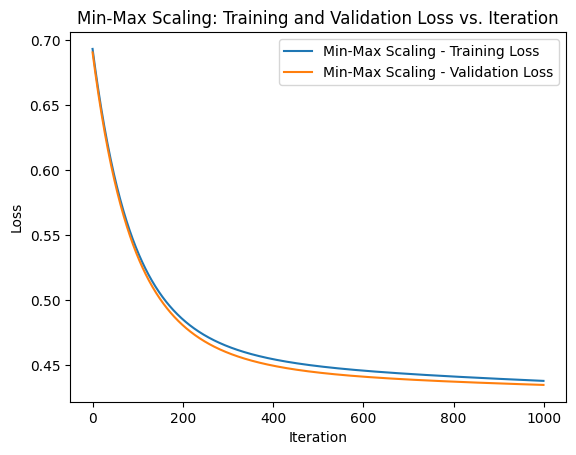

In [ ]:
scaler = MinMaxScaler() #scaler object
scaler.fit(x_train)
#transform the training and validation data
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)

weights_b, bias_b, loss_train_b, acc_train_b, loss_val_b, acc_val_b = lr_bgd(x_train_scaled, y_train, learning_rate, iterations, x_val_scaled, y_val)

#plotting the curves
#no scaling plot from part a
plt.plot(range(iterations), loss_train_a, label='No Scaling - Training Loss')
plt.plot(range(iterations), loss_val_a, label='No Scaling - Validation Loss')
plt.title('No Scaling: Training and Validation Loss vs. Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

#plot after min-max scaling
plt.plot(range(iterations), loss_train_b, label='Min-Max Scaling - Training Loss')
plt.plot(range(iterations), loss_val_b, label='Min-Max Scaling - Validation Loss')
plt.title('Min-Max Scaling: Training and Validation Loss vs. Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

In this case, feature scaling proved to be quite indispensible to comment on model convergence. Only after scaling, we can comprehend the plots where we see decreasing losses with every next iteration.  
The model converges at around 600th iteration, after this losses become too small.  
From this point, we will train our models on scaled data because only those plots are comprehensible.

# c) Performance analysis

Model after min-max scaling performed better and we will analyse that.  
Precision indicates the proportion of correctly predicted positive instances out of all predicted positive instances (accuracy of positive predictions).  
Recall indicates the proportion of correctly predicted positive instances out of all actual positive instances (model's ability to identify all positive instances).  
F1 score is a balanced measure (harmonic mean) of precision and recall.  
ROC-AUC score reflects the model's ability to distinguish between positive and negative instances.


In [ ]:
y_pred = predict(x_val_scaled, weights_b, bias_b, 0.25)

#calculate confusion matrix
cm = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:")
print(cm)

tn, fp, fn, tp = cm.ravel()
print(f"True Positives: {tp}")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")

#calculate precision, recall, F1 score, ROC-AUC score
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred)

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("ROC-AUC Score: ", roc_auc)

Confusion Matrix:
[[539   1]
 [ 96   0]]
True Positives: 0
True Negatives: 539
False Positives: 1
False Negatives: 96
Precision:  0.0
Recall:  0.0
F1 Score:  0.0
ROC-AUC Score:  0.49907407407407406


This indicates that the model predicts no for all instances in the validation set. The large number of true negatives also signify that the dataset is not distributed uniformly and has a lot of no instances. The model cannot figure out yes instances and needs more dataset.

# d) Stochastic and Mini-Batch Gradient Descent

Stochastic Gradient Descent:  
There are two variations of stochastic gradient descent.  
One is called the iterative version where we randomly reorder the dataset before each iteration (epoch) and iterate the reordered dataset and then update weights after each data point. This is more computaionally expensive than Batch Gradient Descent and takes a lot of time.  
Another is where we for each epoch we only process one data point randomly and update weights and move to next iteration. This is faster than Batch Gradient Descent.

Iterative version of SGD

In [ ]:
def sgd_iter(x_train, y_train, learning_rate, iterations, x_val, y_val):
  #convert to numpy arrays
  x_train = x_train.to_numpy()
  y_train = y_train.to_numpy()
  x_val = x_val.to_numpy()
  y_val = y_val.to_numpy()
  n = len(y_train) #number of training samples
  #arrays required to track losses and accuracies for plots
  loss_train = np.zeros(iterations)
  loss_val = np.zeros(iterations)
  acc_train = np.zeros(iterations)
  acc_val = np.zeros(iterations)
  #initialise weights and bias as 0
  weights = np.zeros(x_train.shape[1])
  bias = 0

  for i in range(iterations):
    #randomly reorder the dataset
    indices = np.random.permutation(n)
    x_shuffled = x_train[indices]
    y_shuffled = y_train[indices]

    for j in range(n):
      #loop through each training sample
      x_temp = x_shuffled[j].reshape(1, -1)
      y_temp = y_shuffled[j]
      h_temp = sigmoid(np.dot(x_temp, weights) + bias) #calculate hypothesis
      #calculate gradients
      dw = x_temp.T * (h_temp - y_temp)
      db = h_temp - y_temp
      #update weights and bias
      weights = weights - learning_rate * dw.flatten()
      bias = bias - learning_rate * db

    #calculate the losses
    h_train = sigmoid(np.dot(x_train, weights) + bias)
    loss_train[i] = loss_func(y_train, h_train)
    h_val = sigmoid(np.dot(x_val, weights) + bias) #calculate hypothesis for validation data
    loss_val[i] = loss_func(y_val, h_val)

    #track training accuracy
    train_predictions = predict(x_train, weights, bias)
    acc_train[i] = np.mean(train_predictions == y_train)

    #track validation accuracy
    val_predictions = predict(x_val, weights, bias)
    acc_val[i] = np.mean(val_predictions == y_val)

  return weights, bias, loss_train, acc_train, loss_val, acc_val

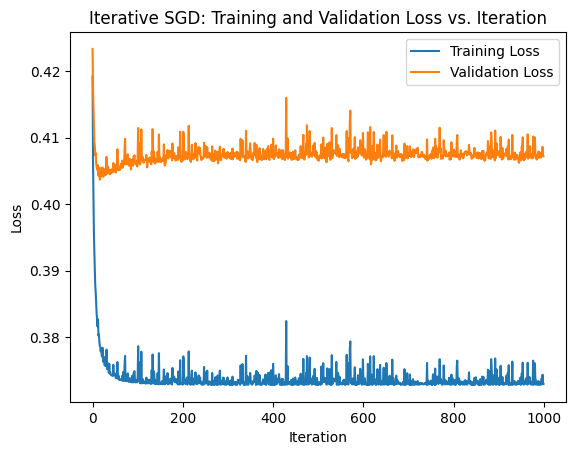

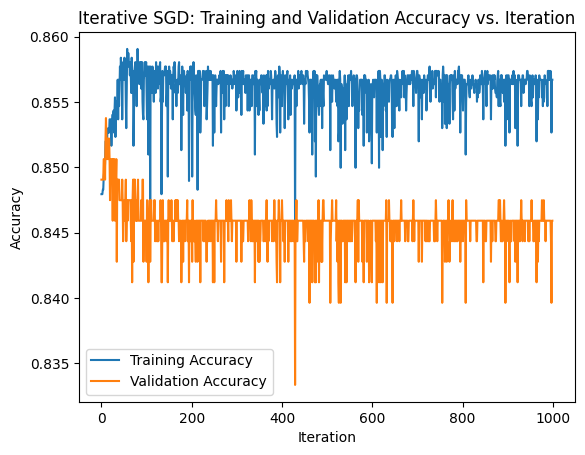

In [ ]:
#training on scaled data
weights_sgd, bias_sgd, loss_train_sgd, acc_train_sgd, loss_val_sgd, acc_val_sgd = sgd_iter(x_train_scaled, y_train, learning_rate, iterations, x_val_scaled, y_val)

#loss vs iteration
plt.plot(range(iterations), loss_train_sgd, label='Training Loss')
plt.plot(range(iterations), loss_val_sgd, label='Validation Loss')
plt.title('Iterative SGD: Training and Validation Loss vs. Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

#accuracy vs iteration
plt.plot(range(iterations), acc_train_sgd, label='Training Accuracy')
plt.plot(range(iterations), acc_val_sgd, label='Validation Accuracy')
plt.title('Iterative SGD: Training and Validation Accuracy vs. Iteration')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Non-iterative version of SGD (more commonly used because it is faster than its other variation)

In [ ]:
def sgd(x_train, y_train, learning_rate, iterations, x_val, y_val):
  #convert to numpy arrays
  x_train = x_train.to_numpy()
  y_train = y_train.to_numpy()
  x_val = x_val.to_numpy()
  y_val = y_val.to_numpy()
  n = len(y_train) #number of training samples
  #arrays required to track losses and accuracies for plots
  loss_train = np.zeros(iterations)
  loss_val = np.zeros(iterations)
  acc_train = np.zeros(iterations)
  acc_val = np.zeros(iterations)
  #initialise weights and bias as 0
  weights = np.zeros(x_train.shape[1])
  bias = 0

  for i in range(iterations):
    #choose a data point randomly
    index = np.random.randint(0, n)
    x_temp = x_train[index]
    y_temp = y_train[index]

    h_temp = sigmoid(np.dot(x_temp, weights) + bias) #calculate hypothesis
    #calculate gradients
    dw = x_temp.T * (h_temp - y_temp)
    db = h_temp - y_temp
    #update weights and bias
    weights = weights - learning_rate * dw.flatten()
    bias = bias - learning_rate * db

    #calculate the losses
    h_train = sigmoid(np.dot(x_train, weights) + bias)
    loss_train[i] = loss_func(y_train, h_train)
    h_val = sigmoid(np.dot(x_val, weights) + bias) #calculate hypothesis for validation data
    loss_val[i] = loss_func(y_val, h_val)

    #track training accuracy
    train_predictions = predict(x_train, weights, bias)
    acc_train[i] = np.mean(train_predictions == y_train)

    #track validation accuracy
    val_predictions = predict(x_val, weights, bias)
    acc_val[i] = np.mean(val_predictions == y_val)

  return weights, bias, loss_train, acc_train, loss_val, acc_val

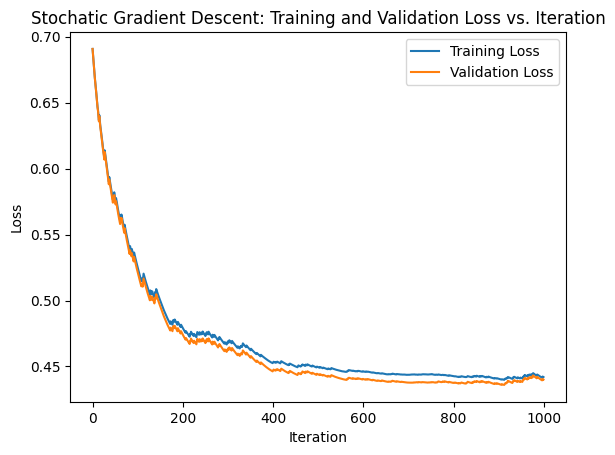

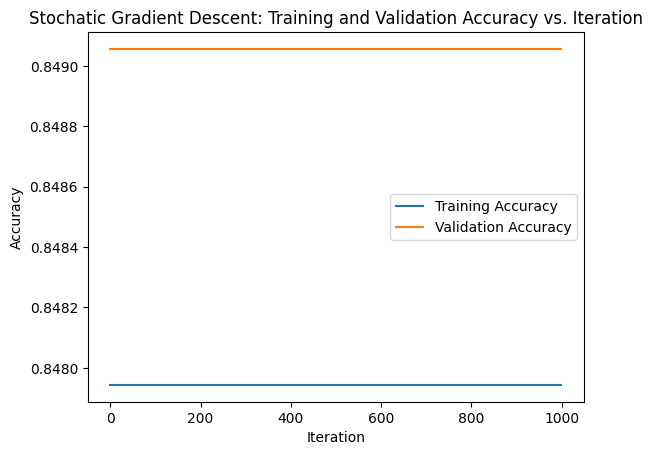

In [ ]:
#train model on scaled data
weights_sgd, bias_sgd, loss_train_sgd, acc_train_sgd, loss_val_sgd, acc_val_sgd = sgd(x_train_scaled, y_train, learning_rate, iterations, x_val_scaled, y_val)

#loss vs iteration
plt.plot(range(iterations), loss_train_sgd, label='Training Loss')
plt.plot(range(iterations), loss_val_sgd, label='Validation Loss')
plt.title('Stochatic Gradient Descent: Training and Validation Loss vs. Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

#accuracy vs iteration
plt.plot(range(iterations), acc_train_sgd, label='Training Accuracy')
plt.plot(range(iterations), acc_val_sgd, label='Validation Accuracy')
plt.title('Stochatic Gradient Descent: Training and Validation Accuracy vs. Iteration')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Mini-Batch Gradient Descent:  
This also has similar two variations as SGD. I have implemented both but used the one that is commonly (non-iteraitve version) used due to its lower expense than BGD and better performance than SGD.

In [ ]:
def mbgd(x_train, y_train, learning_rate, iterations, x_val, y_val, batch_size):
  #convert to numpy arrays
  x_train = x_train.to_numpy()
  y_train = y_train.to_numpy()
  x_val = x_val.to_numpy()
  y_val = y_val.to_numpy()
  n = len(y_train) #number of training samples
  #arrays required to track losses and accuracies for plots
  loss_train = np.zeros(iterations)
  loss_val = np.zeros(iterations)
  acc_train = np.zeros(iterations)
  acc_val = np.zeros(iterations)
  #initialise weights and bias as 0
  weights = np.zeros(x_train.shape[1])
  bias = 0

  for i in range(iterations):
    '''
    #the code block for iterative version of mini-batch gradient descent
    #reorder the dataset before each iteration
    indices = np.random.permutation(n)
    x_shuffled = x_train[indices]
    y_shuffled = y_train[indices]

    for start in range(0, n, batch_size):
      #create batch
      end = min(start + batch_size, n)
      x_batch = x_shuffled[start:end]
      y_batch = y_shuffled[start:end]

      h_batch = sigmoid(np.dot(x_batch, weights) + bias) #calculate hypothesis
      #calculate gradients
      dw = np.dot(x_batch.T, (h_batch - y_batch)) / (end-start) # (end-start) = batch_size
      db = np.sum(h_batch - y_batch) / (end-start)
      #update weights and bias
      weights = weights - learning_rate * dw.flatten()
      bias = bias - learning_rate * db
    '''
    #the code block for non-iterative version of mini-batch gradient descent
    #choose an index randomly
    index = np.random.randint(0, n-batch_size)
    #create batch
    x_batch = x_train[index:index+batch_size]
    y_batch = y_train[index:index+batch_size]

    h_batch = sigmoid(np.dot(x_batch, weights) + bias) #calculate hypothesis
    #calculate gradients
    dw = np.dot(x_batch.T, (h_batch - y_batch)) / batch_size
    db = np.sum(h_batch - y_batch) / batch_size
    #update weights and bias
    weights = weights - learning_rate * dw.flatten()
    bias = bias - learning_rate * db

    #calculate the losses
    h_train = sigmoid(np.dot(x_train, weights) + bias)
    loss_train[i] = loss_func(y_train, h_train)
    h_val = sigmoid(np.dot(x_val, weights) + bias) #calculate hypothesis for validation data
    loss_val[i] = loss_func(y_val, h_val)

    #track training accuracy
    train_predictions = predict(x_train, weights, bias)
    acc_train[i] = np.mean(train_predictions == y_train)

    #track validation accuracy
    val_predictions = predict(x_val, weights, bias)
    acc_val[i] = np.mean(val_predictions == y_val)

  return weights, bias, loss_train, acc_train, loss_val, acc_val

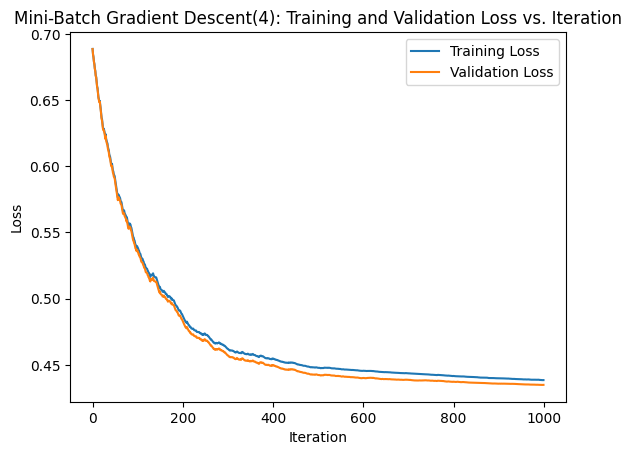

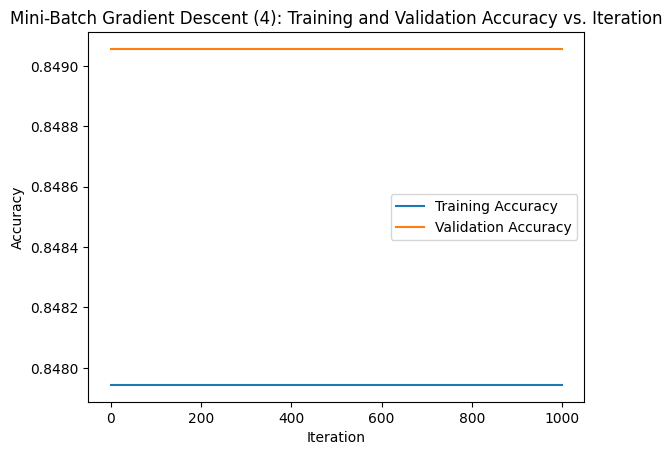

In [ ]:
#training on scaled data with batch size 4
weights_mbgd_4, bias_mbgd_4, loss_train_mbgd_4, acc_train_mbgd_4, loss_val_mbgd_4, acc_val_mbgd_4 = mbgd(x_train_scaled, y_train, learning_rate, iterations, x_val_scaled, y_val, 4)

#loss vs iteration
plt.plot(range(iterations), loss_train_mbgd_4, label='Training Loss')
plt.plot(range(iterations), loss_val_mbgd_4, label='Validation Loss')
plt.title('Mini-Batch Gradient Descent(4): Training and Validation Loss vs. Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

#accuracy vs iteration
plt.plot(range(iterations), acc_train_mbgd_4, label='Training Accuracy')
plt.plot(range(iterations), acc_val_mbgd_4, label='Validation Accuracy')
plt.title('Mini-Batch Gradient Descent (4): Training and Validation Accuracy vs. Iteration')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

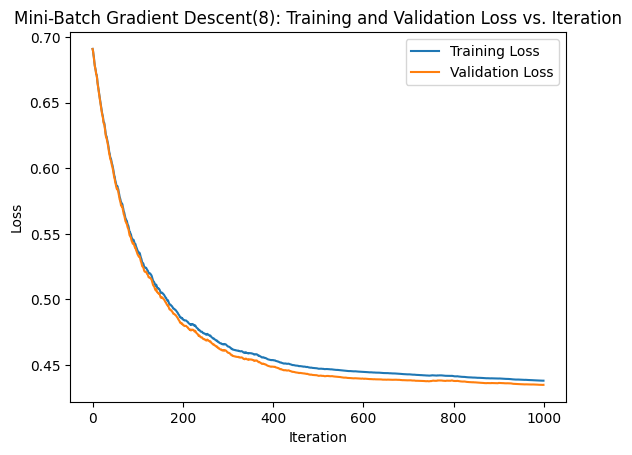

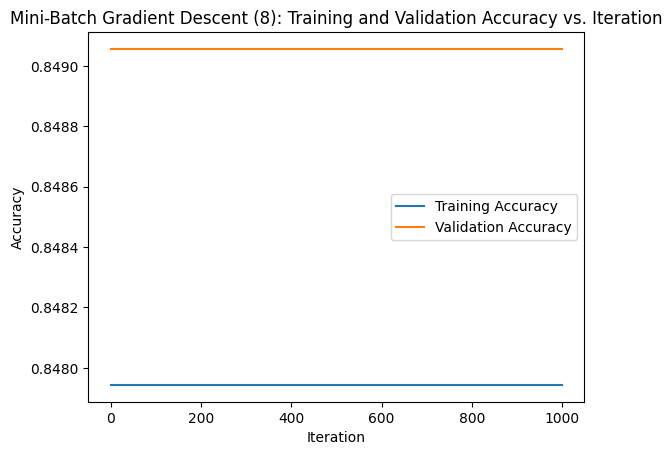

In [ ]:
#training on scaled data with batch size 8
weights_mbgd_8, bias_mbgd_8, loss_train_mbgd_8, acc_train_mbgd_8, loss_val_mbgd_8, acc_val_mbgd_8 = mbgd(x_train_scaled, y_train, learning_rate, iterations, x_val_scaled, y_val, 8)

#loss vs iteration
plt.plot(range(iterations), loss_train_mbgd_8, label='Training Loss')
plt.plot(range(iterations), loss_val_mbgd_8, label='Validation Loss')
plt.title('Mini-Batch Gradient Descent(8): Training and Validation Loss vs. Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

#accuracy vs iteration
plt.plot(range(iterations), acc_train_mbgd_8, label='Training Accuracy')
plt.plot(range(iterations), acc_val_mbgd_8, label='Validation Accuracy')
plt.title('Mini-Batch Gradient Descent (8): Training and Validation Accuracy vs. Iteration')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

From the above plots, we conclude that we reached convergence earlier than the Batch Gradient Descent but the plots have more noise compared to the Batch Gradient Descent.

# e) k-fold cross-validation

We are implementing k-fold cross validation for k=5. This means we create k fold partition of entire dataset and experiment k times by training k-1 folds and validation on remaining fold. (train : validation = 80 : 20)

In [ ]:
def create_folds(x, y, k):
  fold_size = len(y)//k #size of each fold
  indices = np.arange(len(y)) #create a array storing indices
  np.random.shuffle(indices) #shuffle indices to ensure randomness across folds

  folds = [] #will store indices for folds as a tuple of (train_indices, val_indices)
  for i in range(k):
    #select one partition for validation
    val_indices = indices[i*fold_size:(i+1)*fold_size]
    #select k-1 partitions for training
    train_indices = np.concatenate([indices[:i*fold_size], indices[(i+1)*fold_size:]])
    folds.append((train_indices, val_indices))

  return folds

def k_fold_cross_val(x, y, k, lr, iter):
  folds = create_folds(x, y, k) #get folds
  #arrays to store metrics
  acc, prec, rec, f1 = [], [], [], []

  for tr_idx, te_idx in folds:
    #split data into training and validation sets
    x_train, x_val = x[tr_idx], x[te_idx]
    y_train, y_val = y[tr_idx], y[te_idx]

    wts, bis, lt, at, lv, av = lr_bgd(x_train, y_train, lr, iter, x_val, y_val) #train model
    y_val_pred = predict(x_val, wts, bis, 0.25) #predict on validation set

    acc.append(accuracy_score(y_val, y_val_pred))
    prec.append(precision_score(y_val, y_val_pred))
    rec.append(recall_score(y_val, y_val_pred))
    f1.append(f1_score(y_val, y_val_pred))

  return acc, prec, rec, f1

In [ ]:
#using k-fold cross-validation on original dataset(after filling missing values) with batch gradient descent LR model
k_temp = 5 #number of folds
acc, prec, rec, f1 = k_fold_cross_val(x.values, y.values, k_temp, learning_rate, iterations)

print("Testing metrics for folds when model is trained with rest folds:")
for i in range(k_temp):
  print(f'Fold {i+1}: Accuracy = {acc[i]:.4f}, Precision = {prec[i]:.4f}, Recall = {rec[i]:.4f}, F1 Score = {f1[i]:.4f}')

#the required metrics
print(f"\nAccuracy: Average = {np.mean(acc):.4f}, Standard Deviation = {np.std(acc):.4f}")
print(f"Precision: Average = {np.mean(prec):.4f}, Standard Deviation = {np.std(prec):.4f}")
print(f"Recall: Average = {np.mean(rec):.4f}, Standard Deviation = {np.std(rec):.4f}")
print(f"F1 Score: Average = {np.mean(f1):.4f}, Standard Deviation = {np.std(f1):.4f}")

Testing metrics for folds when model is trained with rest folds:
Fold 1: Accuracy = 0.8323, Precision = 0.3514, Recall = 0.0992, F1 Score = 0.1548
Fold 2: Accuracy = 0.8418, Precision = 0.0000, Recall = 0.0000, F1 Score = 0.0000
Fold 3: Accuracy = 0.8418, Precision = 0.0000, Recall = 0.0000, F1 Score = 0.0000
Fold 4: Accuracy = 0.1936, Precision = 0.1521, Recall = 0.9760, F1 Score = 0.2632
Fold 5: Accuracy = 0.8583, Precision = 0.0000, Recall = 0.0000, F1 Score = 0.0000

Accuracy: Average = 0.7136, Standard Deviation = 0.2601
Precision: Average = 0.1007, Standard Deviation = 0.1385
Recall: Average = 0.2150, Standard Deviation = 0.3824
F1 Score: Average = 0.0836, Standard Deviation = 0.1080


Precision, Recall, F1 score are 0 in Folds 2, 3 and 5 indicating that the model didn't predict a single positive outcome in these folds, yet these folds show a high accuracy implying that the dataset is not uniformly distributed (has very less positive instances).  
Fold 4 shows a very high recall and very low accuracy indicates that model predicted many positive values correctly but failed to predict negative values this time.  
The accuracy is stable across all folds except Fold 4, this is clearly depicted in high standard deviation as well. This implies that the dataset has a high variance.  
  
Overall, we can conclude that the model consistently fails to predict positive instances as indicated by average precision and recall and the relatively higher standard deviations indicate instability across folds.


# f) Early stopping

The best model is the logistic regression with BGD because it have a smooth loss vs iteration curve, signifying no noise and steady learning leading to convergence.  
We will stop early if change in model's validation is less than 1e-4 for threshold_iterations.

In [89]:
#function for logistic regression batch gradient descent
#threshold itrations value is 5
def lr_bgd_es(x_train, y_train, learning_rate, iterations, x_val, y_val, thrsh_iter=5):
  n = len(y_train) #number of training samples
  #arrays required to track losses and accuracies for plots
  loss_train = np.zeros(iterations)
  loss_val = np.zeros(iterations)
  acc_train = np.zeros(iterations)
  acc_val = np.zeros(iterations)
  #initialise weights and bias as 0
  weights = np.zeros(x_train.shape[1])
  bias = 0
  #initialise counters for early stopping
  thrsh_loss = np.inf
  cnt = 0
  thrsh_weights = None
  thrsh_bias = None

  for i in range(iterations):
    h_train = sigmoid(np.dot(x_train, weights) + bias) #calculate hypothesis
    #calculate gradients
    dw = np.dot(x_train.T, (h_train - y_train)) / n
    db = np.sum(h_train - y_train) / n
    #update weights and bias
    weights = weights - learning_rate * dw
    bias = bias - learning_rate * db

    #calculate the losses
    loss_train[i] = loss_func(y_train, h_train)
    h_val = sigmoid(np.dot(x_val, weights) + bias) #calculate hypothesis for validation data
    loss_val[i] = loss_func(y_val, h_val)

    #track training accuracy
    train_predictions = predict(x_train, weights, bias)
    acc_train[i] = np.mean(train_predictions == y_train)

    #track validation accuracy
    val_predictions = predict(x_val, weights, bias)
    acc_val[i] = np.mean(val_predictions == y_val)

    #check validation loss for early stopping
    if loss_val[i] < thrsh_loss - 1e-4:
      thrsh_loss = loss_val[i]
      thrsh_weights = weights
      thrsh_bias = bias
      cnt = 0
    else:
      cnt += 1
    #stop iterations if conditions are met
    if cnt >= thrsh_iter:
      print("Early stopping at iteration ", i)
      break

  return weights, bias, loss_train, acc_train, loss_val, acc_val

Early stopping at iteration  681


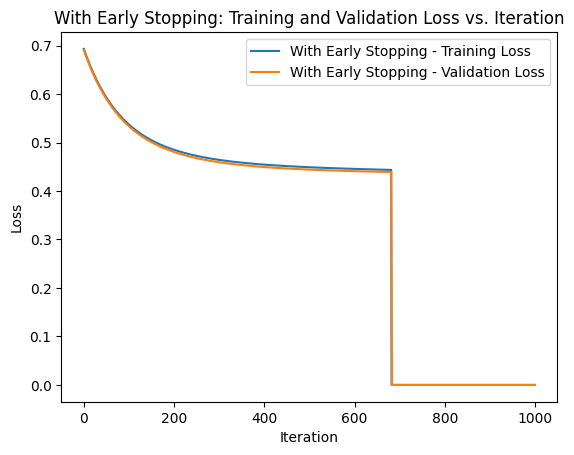

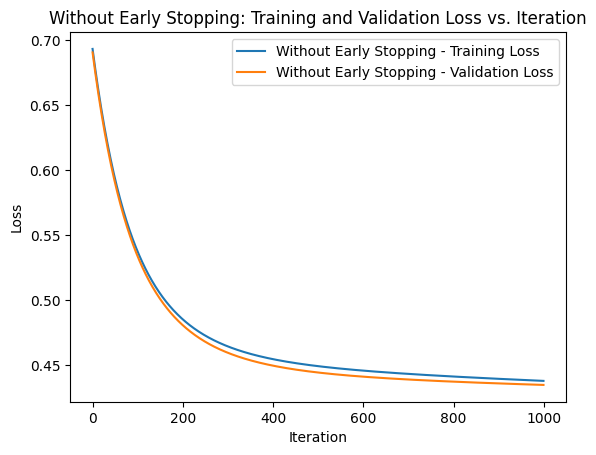

In [90]:
weights_f, bias_f, loss_train_f, acc_train_f, loss_val_f, acc_val_f = lr_bgd_es(x_train_scaled, y_train, learning_rate, iterations, x_val_scaled, y_val)

#plotting the curves
#plot with early stopping
plt.plot(range(iterations), loss_train_f, label='With Early Stopping - Training Loss')
plt.plot(range(iterations), loss_val_f, label='With Early Stopping - Validation Loss')
plt.title('With Early Stopping: Training and Validation Loss vs. Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

#plot from part b without early stopping
plt.plot(range(iterations), loss_train_b, label='Without Early Stopping - Training Loss')
plt.plot(range(iterations), loss_val_b, label='Without Early Stopping - Validation Loss')
plt.title('Without Early Stopping: Training and Validation Loss vs. Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

We can see that the early stopping function stops the model training as the change in validation goes below 0.0001. We also observe that as we increase the learning rate, our model converges faster and without the incorporation of early stopping, the model would begin to overfit the training data and will not be able to generalise on unseen data.